In [1]:
import mitsuba as mi
mi.set_variant('scalar_rgb')
tent_rfilter = mi.load_dict({'type' : 'tent'})
mi.set_variant("llvm_ad_rgb")
import drjit as dr

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np

import os
base_dir = 'estimator_comparison_optimization'
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

In [12]:
# Select scene, (1 or 2)
scene_idx = 1

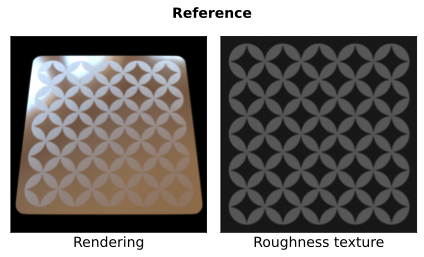

In [13]:
assert scene_idx == 1 or scene_idx == 2
scene_name = 'scenes/roughness_optimization_{}.xml'.format(scene_idx)
scene = mi.load_file(scene_name, method='primal_mis')

params = mi.traverse(scene)
opt_key = 'plane.bsdf.alpha.data'

# Render reference image
image_ref = mi.render(scene, seed=0, spp=128)

# Save reference images
outname = "{}/s{}_reference.jpg".format(base_dir, scene_idx)
image_ref_bm = mi.util.convert_to_bitmap(image_ref)
image_ref_bm.write(outname)

params_ref = params[opt_key]
outname = "{}/s{}_tex_reference.jpg".format(base_dir, scene_idx)
params_ref_bm = mi.util.convert_to_bitmap(params_ref).convert(mi.Bitmap.PixelFormat.RGB,
                                                              mi.Struct.Type.UInt8, False)
params_ref_bm.write(outname)

# Plot
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(image_ref_bm); ax[0].set_xlabel("Rendering", size=14)
ax[1].imshow(params_ref_bm); ax[1].set_xlabel("Roughness texture", size=14)
fig.suptitle("Reference", weight='bold', y=0.9, size=14)
for ax_ in ax:
    ax_.set_xticks([]); ax_.set_yticks([])
plt.tight_layout()
plt.show()

In [14]:
# Initialize textured roughness with random values
np.random.seed(0)
init_res = 32
scale = 0.5 if scene_idx == 1 else 0.3
initial_values = mi.Bitmap((scale*np.random.uniform(size=init_res**2)).reshape(init_res, init_res, -1))

# Upsample texture to full resolution
opt_res = 128
upsampled_values = np.array(initial_values.resample([opt_res, opt_res], tent_rfilter))[..., np.newaxis]
upsampled_values = mi.TensorXf(upsampled_values)

In [15]:
# Optimization parameters
learning_rate = 120.0
spp_primal = 32
spp_grad   = 4

save_renderings = True
save_parameters = True

def rel_l1_loss(img):
    # Relative L1 loss
    return dr.sum(dr.abs(img - image_ref) / (dr.maximum(dr.abs(image_ref), 0.001))) / len(img)

mi.Thread.thread().logger().set_log_level(mi.LogLevel.Error)

methods = [
    'bs_detached',
    'bs_attached',
    'bs_detached_diff'
]
method_losses = []

for method in methods:
    print("* Method: {}".format(method))
    # Load scene with specified estimator
    scene = mi.load_file(scene_name)
    integrator = mi.load_dict({'type': 'estimator_comparison', 'method': method, 'hide_emitters': True})
    
    image_init = mi.render(scene, seed=0, spp=128)
    mi.util.convert_to_bitmap(image_init)
    
    params = mi.traverse(scene)
    params[opt_key] = upsampled_values
    params.update()

    # Standard stochastic gradient descent optimizer
    opt = mi.ad.optimizers.SGD(lr=learning_rate)
    
    opt[opt_key] = params[opt_key]
    params.update(opt)
    
    losses = []
    n_iterations = 100
    for it in range(n_iterations): 
        if 'diff' in method:
            # Differential sampling strategy, use antithetic sampling.
            # Note that we use the same seed twice, and use half the number of samples for each pass.
            grads = mi.Float(0.0)
            
            image = mi.render(scene, params, integrator=integrator, seed=it,
                              spp=spp_primal, spp_grad=spp_grad//2, antithetic_pass=False)
            loss = rel_l1_loss(image)
            dr.backward(loss)
            
            image = mi.render(scene, params, integrator=integrator, seed=it,
                              spp=spp_primal, spp_grad=spp_grad//2, antithetic_pass=True)
            loss = rel_l1_loss(image)
            dr.backward(loss)

            # Average accumulated gradients from both passes
            dr.set_grad(opt[opt_key], 0.5*dr.grad(opt[opt_key]))
        else:
            # Rendering of current state
            image = mi.render(scene, params, integrator=integrator, seed=it,
                              spp=spp_primal, spp_grad=spp_grad)

            # Apply loss function
            loss = rel_l1_loss(image)

            # Backpropagate
            dr.backward(loss)
            
        # Optionally save intermediate renderings and parameter textures
        if save_renderings:
            outname = "{}/s{}_{}_it{:03d}.jpg".format(base_dir, scene_idx, method, it)
            image_bm = mi.util.convert_to_bitmap(image, uint8_srgb=True)
            image_bm.write(outname)
        if save_parameters:
            outname = "{}/s{}_{}_tex_it{:03d}.jpg".format(base_dir, scene_idx, method, it)
            params_bm = mi.util.convert_to_bitmap(opt[opt_key], uint8_srgb=False)
            params_bm = params_bm.convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, False)
            params_bm.write(outname)

        # Optimizer: take a gradient step
        opt.step()

        opt[opt_key] = dr.clamp(opt[opt_key], 1e-2, 1.0)

        # Optimizer: Update the scene parameters
        params.update(opt)

        print('  Iteration {:03d}: loss={:.5f}'.format(it, loss[0]), end='\r')
        losses.append(loss)   
        
    method_losses.append(losses)
    print()

* Method: bs_detached
  Iteration 099: loss=0.05904
* Method: bs_attached
  Iteration 099: loss=0.20308
* Method: bs_detached_diff
  Iteration 099: loss=0.05595


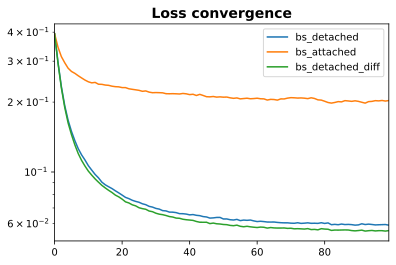

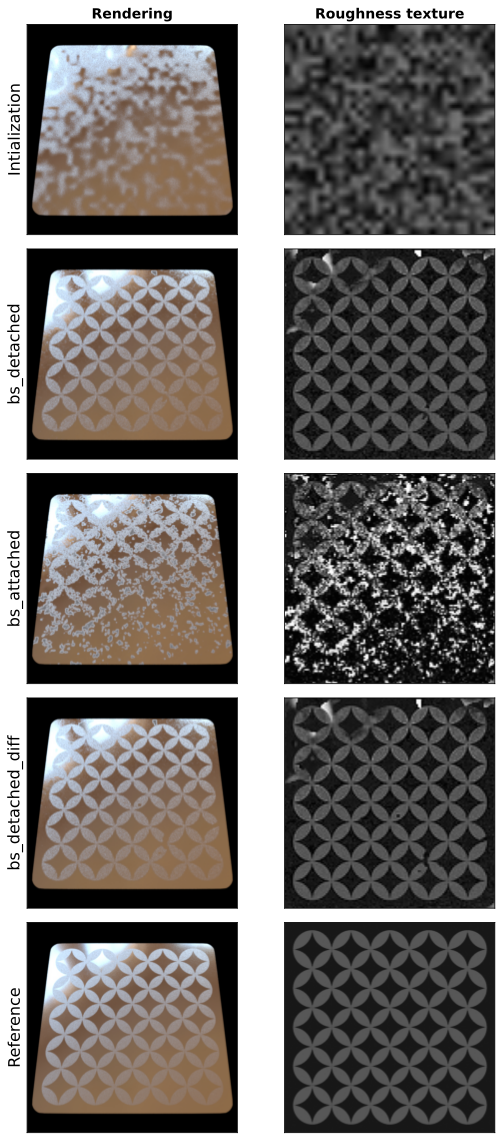

In [16]:
plt.figure()
for idx, method in enumerate(methods):
    plt.semilogy(method_losses[idx], label=method)
plt.legend()
plt.title("Loss convergence", weight='bold', size=14)
plt.xlim([0, 99])
plt.show()

def plot_img(ax, path):
    bm = mi.Bitmap(path)
    ax.imshow(bm)

fig, ax = plt.subplots(ncols=2, nrows=len(methods)+2, figsize=(8, 16))

plot_img(ax[0, 0], "{}/s{}_{}_it{:03d}.jpg".format(base_dir, scene_idx, methods[0], 0))
plot_img(ax[0, 1], "{}/s{}_{}_tex_it{:03d}.jpg".format(base_dir, scene_idx, methods[0], 0))
    
for idx, method in enumerate(methods):
    plot_img(ax[1+idx, 0], "{}/s{}_{}_it{:03d}.jpg".format(base_dir, scene_idx, method, n_iterations-1))
    plot_img(ax[1+idx, 1], "{}/s{}_{}_tex_it{:03d}.jpg".format(base_dir, scene_idx, method, n_iterations-1))
    
plot_img(ax[len(methods)+1, 0], "{}/s{}_reference.jpg".format(base_dir, scene_idx))
plot_img(ax[len(methods)+1, 1], "{}/s{}_tex_reference.jpg".format(base_dir, scene_idx))

for ax_ in ax.flatten():
    ax_.set_xticks([]); ax_.set_yticks([])
    
ax[0, 0].set_title("Rendering", weight='bold', size=14)
ax[0, 1].set_title("Roughness texture", weight='bold', size=14)
for idx, method in enumerate(methods):
    ax[1+idx, 0].set_ylabel(method, size=16)
ax[0, 0].set_ylabel("Intialization", size=16)


ax[len(methods)+1, 0].set_ylabel("Reference", size=16)

plt.tight_layout()
plt.show()